# Clustering com Embeddings (Gemini ou Sentence-Transformers)

**Objetivo:** Executar clustering e visualização 2D sobre os embeddings gerados (via Gemini API ou sentence-transformers local).

**Nota:** Este notebook funciona com embeddings gerados tanto pelo Google Gemini API quanto pelo sentence-transformers (alternativa local).


In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

# Tentar importar UMAP, se não disponível usar TSNE
# Nota: umap-learn requer Python < 3.14 devido ao numba
# Se você está no Python 3.14+, o código usará t-SNE automaticamente
# (Erros de linting sobre 'umap' podem ser ignorados)
try:
    import umap
    USE_UMAP = True
    print("UMAP disponível - será usado para visualização")
except ImportError:
    USE_UMAP = False
    print("="*60)
    print("AVISO: umap-learn não está instalado ou não é compatível.")
    print("Usando t-SNE como alternativa (funciona perfeitamente!).")
    print("")
    print("Para instalar UMAP (requer Python < 3.14):")
    print("  pip install umap-learn")
    print("")
    print("Nota: Com Python 3.14, você DEVE usar t-SNE (já configurado).")
    print("="*60)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


c:\ClassicVsModernNLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP disponível - será usado para visualização


## 1. Carregar embeddings


In [2]:
# Carregar embeddings
# Nota: O arquivo pode conter embeddings do Gemini API ou sentence-transformers
with open('../data/processed/embeddings_gemini.pkl', 'rb') as f:
    data = pickle.load(f)

X_emb = data['X_emb']
y = data['y']  # rótulos verdadeiros para comparação
target_names = data['target_names']
model_name = data.get('model_name', 'unknown')

print(f"Shape dos dados: {X_emb.shape}")
print(f"Modelo usado para gerar embeddings: {model_name}")
print(f"Classes verdadeiras: {target_names}")
print(f"Dimensão do embedding: {X_emb.shape[1]}")

Shape dos dados: (5611, 384)
Modelo usado para gerar embeddings: sentence-transformers/all-MiniLM-L6-v2
Classes verdadeiras: ['rec.autos', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.space', 'talk.politics.guns', 'talk.politics.mideast']
Dimensão do embedding: 384


## 2. Redução Dimensional: PCA → UMAP


In [3]:
# Aplicar PCA (50 componentes)
print("Aplicando PCA (50 componentes)...")
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_emb)

print(f"Variance explained by 50 components: {pca.explained_variance_ratio_.sum():.4f}")

# Aplicar redução dimensional para visualização (UMAP ou TSNE)
if USE_UMAP:
    print("Aplicando UMAP (2D)...")
    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_vis = umap_reducer.fit_transform(X_pca)
    vis_method = "UMAP"
else:
    print("Aplicando t-SNE (2D) como alternativa...")
    tsne_reducer = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    X_vis = tsne_reducer.fit_transform(X_pca)
    vis_method = "t-SNE"

print(f"Shape após redução ({vis_method}): {X_vis.shape}")


Aplicando PCA (50 componentes)...
Variance explained by 50 components: 0.5668
Aplicando UMAP (2D)...


c:\ClassicVsModernNLP\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape após redução (UMAP): (5611, 2)


## 3. Clustering: K-Means (k=6)


In [4]:
# K-Means com k=6
print("Executando K-Means (k=6)...")
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_pca)  # usar PCA, não UMAP, para clustering

# Métricas
silhouette_kmeans = silhouette_score(X_pca, clusters_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(X_pca, clusters_kmeans)

print(f"K-Means Silhouette Score: {silhouette_kmeans:.4f}")
print(f"K-Means Davies-Bouldin Index: {davies_bouldin_kmeans:.4f}")
print(f"Número de clusters encontrados: {len(np.unique(clusters_kmeans))}")
print(f"Distribuição dos clusters: {pd.Series(clusters_kmeans).value_counts().sort_index().to_dict()}")


Executando K-Means (k=6)...
K-Means Silhouette Score: 0.0922
K-Means Davies-Bouldin Index: 2.8591
Número de clusters encontrados: 6
Distribuição dos clusters: {0: 968, 1: 762, 2: 873, 3: 1394, 4: 813, 5: 801}


## 4. Clustering: DBSCAN


In [5]:
# DBSCAN - tentar encontrar bons parâmetros
print("Executando DBSCAN...")

# Tentar diferentes valores de eps
best_dbscan = None
best_silhouette = -1
best_eps = None

eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
min_samples_values = [5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters_dbscan = dbscan.fit_predict(X_pca)
        
        n_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
        n_noise = list(clusters_dbscan).count(-1)
        
        # Só calcular métricas se houver pelo menos 2 clusters
        if n_clusters >= 2:
            try:
                silhouette = silhouette_score(X_pca[clusters_dbscan != -1], 
                                              clusters_dbscan[clusters_dbscan != -1])
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_dbscan = dbscan
                    best_eps = eps
            except:
                pass

if best_dbscan is not None:
    clusters_dbscan = best_dbscan.fit_predict(X_pca)
    silhouette_dbscan = silhouette_score(X_pca[clusters_dbscan != -1], 
                                         clusters_dbscan[clusters_dbscan != -1])
    davies_bouldin_dbscan = davies_bouldin_score(X_pca[clusters_dbscan != -1], 
                                                clusters_dbscan[clusters_dbscan != -1])
    print(f"DBSCAN (eps={best_eps}) Silhouette Score: {silhouette_dbscan:.4f}")
    print(f"DBSCAN Davies-Bouldin Index: {davies_bouldin_dbscan:.4f}")
else:
    # Usar valores padrão
    dbscan = DBSCAN(eps=0.5, min_samples=10)
    clusters_dbscan = dbscan.fit_predict(X_pca)
    silhouette_dbscan = silhouette_score(X_pca[clusters_dbscan != -1], 
                                         clusters_dbscan[clusters_dbscan != -1]) if len(np.unique(clusters_dbscan[clusters_dbscan != -1])) > 1 else -1
    davies_bouldin_dbscan = davies_bouldin_score(X_pca[clusters_dbscan != -1], 
                                                 clusters_dbscan[clusters_dbscan != -1]) if len(np.unique(clusters_dbscan[clusters_dbscan != -1])) > 1 else float('inf')

n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise_dbscan = list(clusters_dbscan).count(-1)

print(f"Número de clusters encontrados: {n_clusters_dbscan}")
print(f"Pontos classificados como ruído: {n_noise_dbscan}")
print(f"Distribuição dos clusters: {pd.Series(clusters_dbscan).value_counts().sort_index().to_dict()}")


Executando DBSCAN...
DBSCAN (eps=0.3) Silhouette Score: 0.7863
DBSCAN Davies-Bouldin Index: 0.3042
Número de clusters encontrados: 4
Pontos classificados como ruído: 5583
Distribuição dos clusters: {-1: 5583, 0: 5, 1: 6, 2: 10, 3: 7}


## 5. Visualização dos Clusters



Figura salva em: ../reports/figures/clustering_embeddings_umap.png


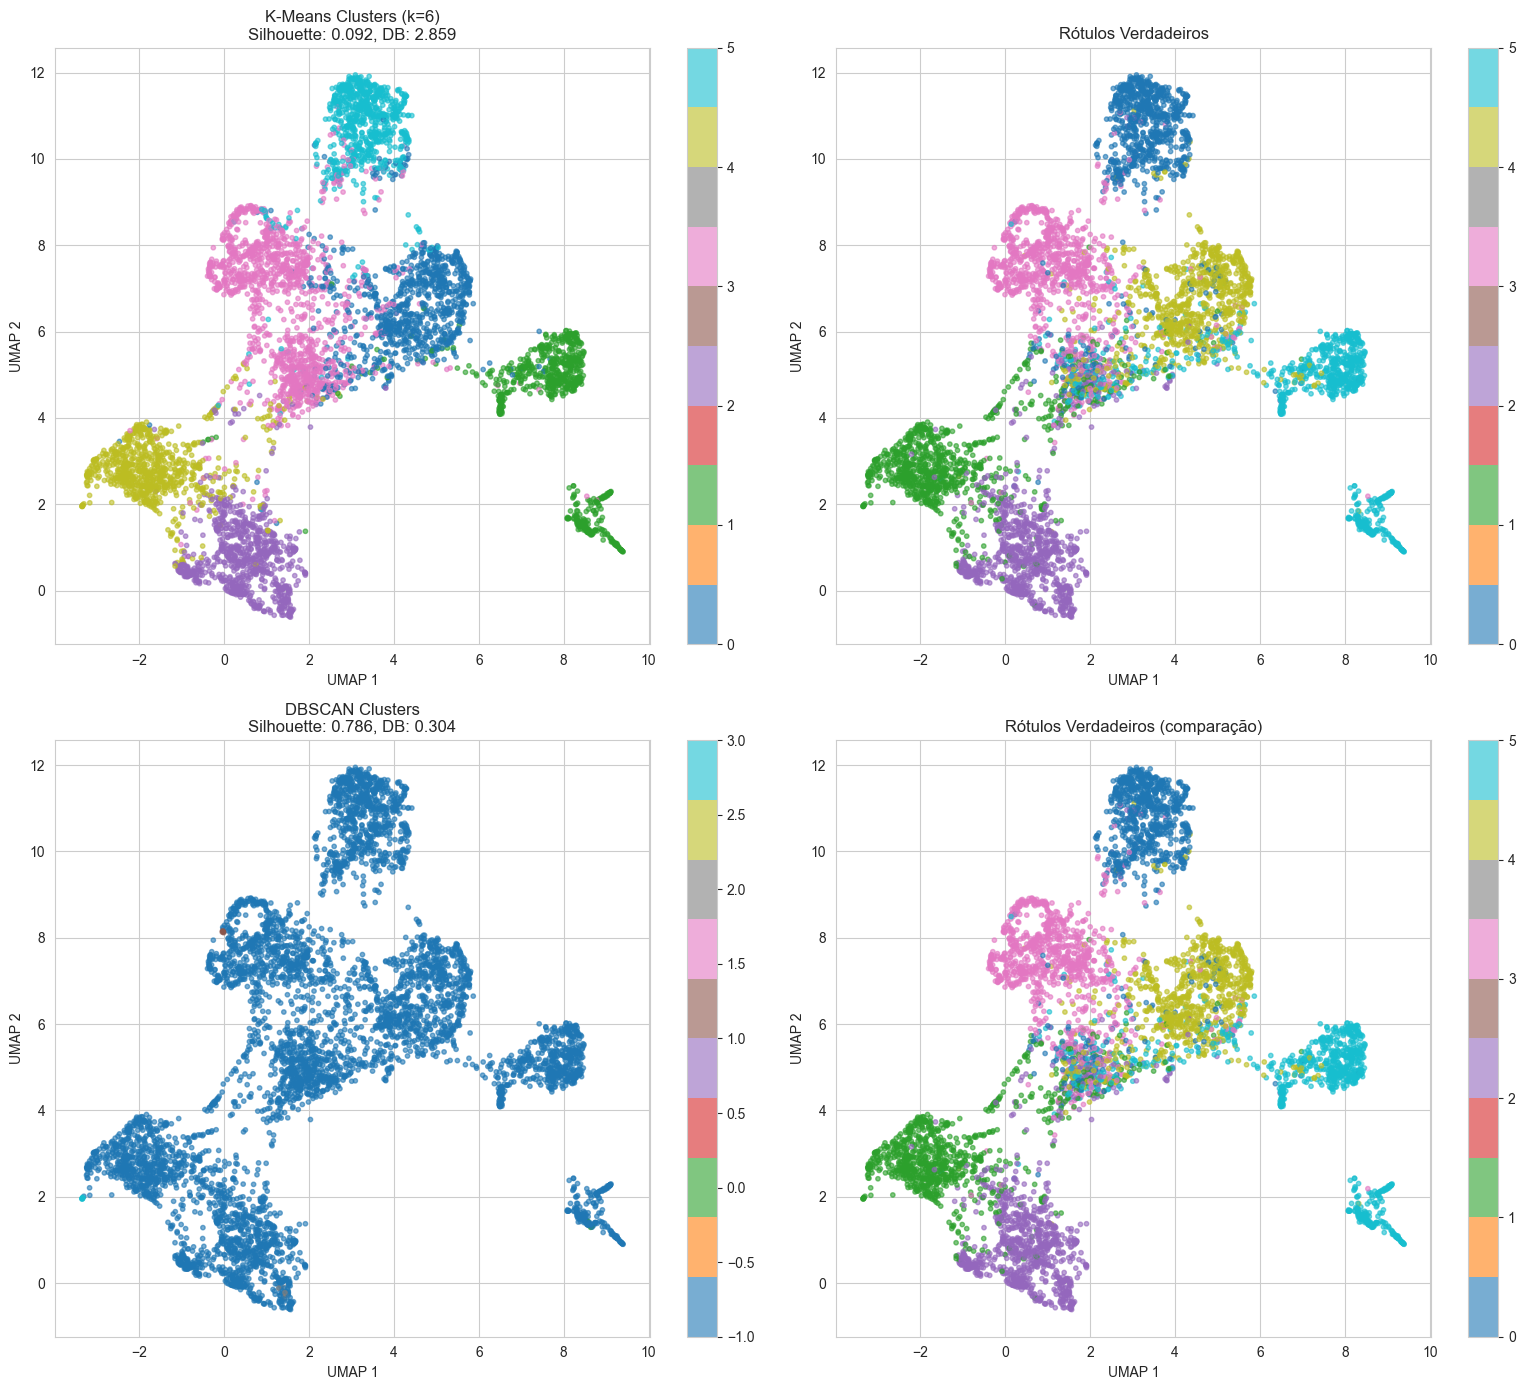

In [6]:
# Criar diretório para figuras
os.makedirs('../reports/figures', exist_ok=True)
os.makedirs('../reports/metrics', exist_ok=True)

# Visualizar clusters K-Means
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# K-Means clusters
ax = axes[0, 0]
scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=clusters_kmeans, 
                     cmap='tab10', alpha=0.6, s=10)
ax.set_title(f'K-Means Clusters (k=6)\nSilhouette: {silhouette_kmeans:.3f}, DB: {davies_bouldin_kmeans:.3f}')
ax.set_xlabel(f'{vis_method} 1')
ax.set_ylabel(f'{vis_method} 2')
plt.colorbar(scatter, ax=ax)

# K-Means vs Rótulos verdadeiros
ax = axes[0, 1]
scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y, 
                     cmap='tab10', alpha=0.6, s=10)
ax.set_title('Rótulos Verdadeiros')
ax.set_xlabel(f'{vis_method} 1')
ax.set_ylabel(f'{vis_method} 2')
plt.colorbar(scatter, ax=ax)

# DBSCAN clusters
ax = axes[1, 0]
scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=clusters_dbscan, 
                     cmap='tab10', alpha=0.6, s=10)
ax.set_title(f'DBSCAN Clusters\nSilhouette: {silhouette_dbscan:.3f}, DB: {davies_bouldin_dbscan:.3f}')
ax.set_xlabel(f'{vis_method} 1')
ax.set_ylabel(f'{vis_method} 2')
plt.colorbar(scatter, ax=ax)

# DBSCAN vs Rótulos verdadeiros (para comparação)
ax = axes[1, 1]
scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y, 
                     cmap='tab10', alpha=0.6, s=10)
ax.set_title('Rótulos Verdadeiros (comparação)')
ax.set_xlabel(f'{vis_method} 1')
ax.set_ylabel(f'{vis_method} 2')
plt.colorbar(scatter, ax=ax)

plt.tight_layout()
# Nome do arquivo genérico que funciona com ambos os métodos de redução dimensional
filename = f'../reports/figures/clustering_embeddings_{vis_method.lower()}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"\nFigura salva em: {filename}")
plt.show()


## 6. Salvar métricas e resultados


In [7]:
# Criar DataFrame com métricas
metrics_df = pd.DataFrame({
    'K-Means': {
        'Silhouette Score': silhouette_kmeans,
        'Davies-Bouldin Index': davies_bouldin_kmeans,
        'Número de Clusters': len(np.unique(clusters_kmeans))
    },
    'DBSCAN': {
        'Silhouette Score': silhouette_dbscan,
        'Davies-Bouldin Index': davies_bouldin_dbscan,
        'Número de Clusters': n_clusters_dbscan,
        'Pontos de Ruído': n_noise_dbscan
    }
}).T

print("Métricas de Clustering:")
print(metrics_df)

# Salvar métricas
metrics_df.to_csv('../reports/metrics/clustering_embeddings_metrics.csv')
print(f"\nMétricas salvas em: ../reports/metrics/clustering_embeddings_metrics.csv")


Métricas de Clustering:
         Silhouette Score  Davies-Bouldin Index  Número de Clusters  \
K-Means          0.092217              2.859117                 6.0   
DBSCAN           0.786258              0.304216                 4.0   

         Pontos de Ruído  
K-Means              NaN  
DBSCAN            5583.0  

Métricas salvas em: ../reports/metrics/clustering_embeddings_metrics.csv
